# CVA calculation for an Interest Rate Swap

In [37]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # to apply percentage formatting to labels

%matplotlib inline

In [123]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# pylab.rcParams['figure.figsize'] = (20, 10)

In this report we show how to calculate the Credit Valuation Adjustment (CVA) taken by Counterparty 'A' to the price of an Interest Rate Swap (IRS) using the credit spreads for Counerparty B.

The inputs for the CVA calculation are:

* Default Probabilities (PDs)
* Forward LIBORs
* Discount Factors (DFs)

Below we discuss each of these aspects separately.

Additional assumptions for this calculation are:

* The IRS is assumed to be written on a 6M LIBOR $L_{6M}$ expiring in 5Y, hence the payment frequency is $\tau=0.5$
* The notional is assumed to be $N=1$

## Default Probabilities

The Default Probabilities are implied from Credit Default Swaps (CDS) spreads using the bootstrapping technique.

### CDS bootstrapping

The bootstrapping formula used was:

$$
P(T_N) = \frac{ \sum^{N−1}_{n=1} D(0, T_n)
[ LP(T_n−1) − (L+ \Delta t_n S_N) P(T_n)]}
{ D(0, T_N)(L+ \Delta t_n S_N) }
+
\frac{P(T_{N−1})L}
{(L+\Delta t_N S_N)}
$$

where $P$ is the survival probability, $L = 1-R$ is the loss calculated from the recovery rate $R$, $\Delta t$ is the payment frequency, $S$ is the spread and $D$ is the discount factor

* The counterparty B in this case was chosen to be an airline company - AirFrance ("AIRF")
* The CDS spreads were taken from Reuters on 27-Jun-2016 and are assumed to apply also for the period 31-May-2013 to 31-May-2016, which was used to calibrate the HJM model (see below)
* The Recovery Rate is assumed to be 40%
* Linear interpolation is used to approximate the CDS spreads at the half increments for which there wasn't market data available
* For consistency and simplicity, the Discount Factors used were the same as those implied from the HJM model after taking their average for each tenor (see methodology below)
* The full calculation can be found in the project repository file "_CVA/my CDS Bootstrapping v2.xlsx_"

The table below summarises the results for each of the tenors $[0.0, 1.0, \dots, 5.0]$, with 'DF' as the discount factor, 'Lambda' as the hazard rate $\lambda_i$, 'PD' as the default probability $PD(T_i, T_{i-1}) = P(T_{i-1}) - P(T_i)$ and 'P' as the survival probability. Note that by definition $PD$ is over a period, whereas $P$ is cumulative.

In [71]:
data2 = pd.read_csv("input.csv", index_col=0)
out = data2.to_string(formatters={'Lambda': '{:,.4%}'.format, 
                            'PD': '{:,.4%}'.format, 
                            'P': '{:,.4%}'.format
                           })
print(out)

           CDS        DF  Lambda      PD         P
Tenor                                             
0.0        NaN  1.000000    nan%    nan% 100.0000%
0.5    114.400  0.995835 1.8976% 0.9443%  99.0557%
1.0    133.770  0.990963 2.2197% 1.2510%  97.8047%
1.5    167.180  0.985697 2.7798% 1.8887%  95.9161%
2.0    200.590  0.980105 3.3452% 2.3875%  93.5285%
2.5    233.965  0.974101 3.9174% 2.8579%  90.6707%
3.0    267.340  0.967832 4.4994% 3.2974%  87.3732%
3.5    296.545  0.961232 5.0170% 3.4776%  83.8957%
4.0    325.750  0.954239 5.5471% 3.7947%  80.1009%
4.5    353.200  0.946899 6.0576% 3.9605%  76.1405%
5.0    380.650  0.939187 6.5842% 4.1914%  71.9490%


The figures below show the period default probability $PD(T_i, T_{i-1}) = P(T_{i-1})$ and the hazard rates $\lambda_i$ are not flat but actually have a term structure, which hence should be accounted in our CVA. The cumulative distribution for $P$ shows how the survival probability decreases with time as expected (and viceversa for the cumulative $PD$ since by definition this is equal to $1 - P$).

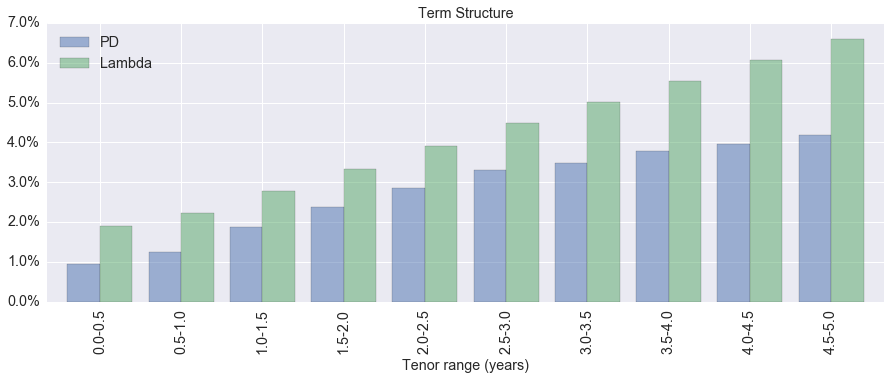

In [124]:
index_interpol = ['0.0-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5',
                  '4.5-5.0']
df =  data2[['PD', 'Lambda']].iloc[1:]
df.index = index_interpol
# ax = df.plot(kind='bar', width=0.8, alpha=0.5, title='Default Probability \n $PD(T_i, T_{i-1}) = P(T_{i-1}) - P(T_i)$')
ax = df.plot(kind='bar', width=0.8, alpha=0.5, title="Term Structure")
# ax = data2['Lambda'].plot(kind='bar', width=0.8, alpha=0.5)
ax.set_xlabel('Tenor range (years)')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))  # applies % formatting to y labels
# ax.set_ylabel('PD')

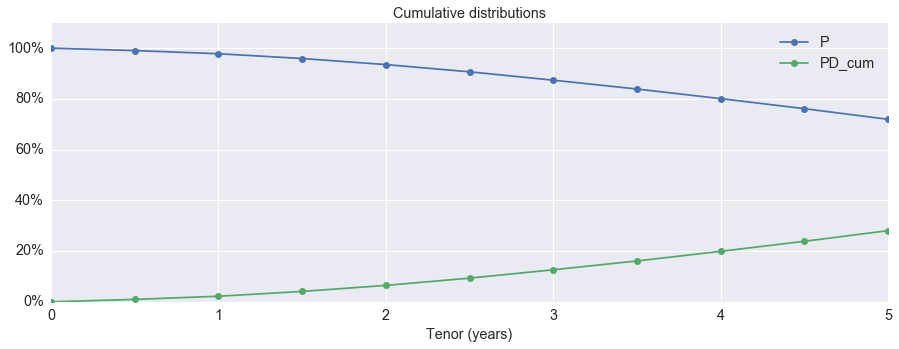

In [125]:
df =  pd.concat([data2['P'], 1-data2['P']], keys=['P', 'PD_cum'], axis=1)
# out = df.to_string(formatters={'P': '{:,.2%}'.format, 
#                             'PD_cum': '{:,.2%}'.format
#                            })
# print(out)

ax = df.plot(marker='o', title="Cumulative distributions", ylim=(0, 1.1))
ax.set_xlabel('Tenor (years)')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

## Forward LIBORs

The Forward LIBOR was obtained by simulating the forward curves with the HJM model. However, this had to be calibrated to recent data to give a more realistic picture of the CVA value. The steps taken are described in detail below.

### PCA

#### Dataset

The HJM model requires a set of volatility functions which are estimated using Principal Component Analysis (PCA) on historical forward rates. 

* To calibrate these functions to recent data, the forward rates were taken from the Bank of England Bank Liability Curve (BLC) for the period 31-May-2013 to 31-May-2016 (worth 3 years or 759 data points). The data can be found at:
  * [ukblc16_mdaily.xlsx](http://www.bankofengland.co.uk/statistics/Documents/yieldcurve/ukblc16_mdaily.xlsx)
  * [ukblc05_mdaily.xlsx](http://www.bankofengland.co.uk/statistics/Documents/yieldcurve/ukblc05_mdaily.xlsx)

* Although we only need the short-end of the curve for the CVA calculation, we take the full curve to calibrate the HJM model, i.e. up the $25Y$ tenor. The dataset is hence constructed by taking the BLC forward curve short-end data (_"1. fwds,short end"_ tab) for the tenors  $[0.5Y, 1.0Y, 1.5Y, ..., 5Y]$ as it offers a better approximation to the short-end, and for the remaining tenors $[5.5Y, ..., 25.0Y]$ we use the full approximation (_"2. fwd curve"_ tab)

* The forward rate for the tenor $0.08Y$ in _"1. fwds,short end"_ is used as a a proxy for the spot rate tenor $0.0Y$, i.e. $r(t) = f(t;t)$

* Dates with missing data values were removed

* The resulting dataset is found in the project reporsitory under "CVA/PCA/my_ukblc_310513_310516.xlsx" and this was pasted into the "data" tab of "_HJM Model - PCA.XLSM_" to run the PCA


The figure below shows the forward curve for four sample dates spanning different years in the dataset. This shows how the curve can move for each of the tenors, for example, at the long-end of the curve the rates have decreased substantially in 2016 compared to 3 years ago. At the short-end of the curve we see the rates tend to increase with tenor as expected.

In [132]:
df = pd.read_excel("PCA/my HJM Model - PCA.xlsm", sheetname="Data", index_col=0)

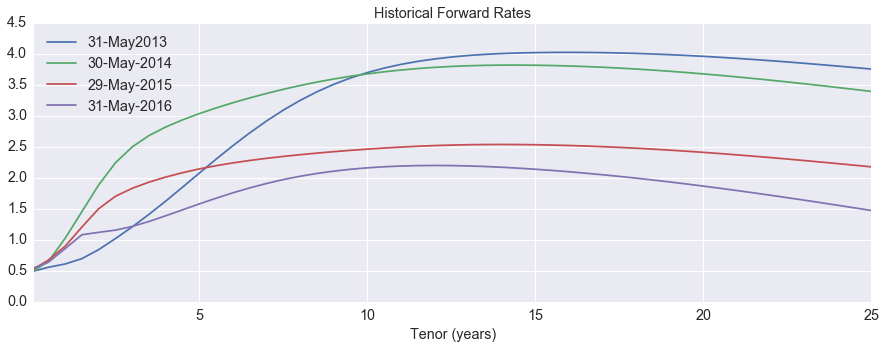

In [133]:
# _ = df.iloc[0, :].plot(figsize=(20, 10), label="1st row")
# _ = df.iloc[379, :].plot(figsize=(20, 10), label="380th row")
# _ = df.iloc[749, :].plot(figsize=(20, 10), label="750th row")
_ = df.iloc[0, :].plot(label="31-May2013", title="Historical Forward Rates")
_ = df.iloc[252, :].plot(label="30-May-2014")
_ = df.iloc[504, :].plot(label="29-May-2015")
_ = df.iloc[758, :].plot(label="31-May-2016")
_ = plt.legend(loc='upper left')
_ = plt.xlabel('Tenor (years)', fontsize='x-large')

The figure below shows the historical evolution of the rate in the dataset for 3 example tenors. The $0.08Y$ tenor is a proxy for the spot rate. This shows the spot rate has remained pretty constant throughout. The rate increases for the shorter tenors but then decreases for the longer tenors - so is the case for 25Y vs 10Y below. This could be interpreted as a lack of liquidity for the longer tenors.

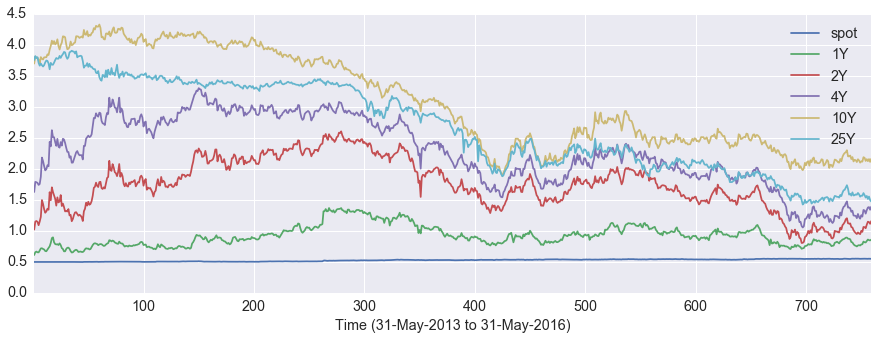

In [146]:
_ = df[0.08].plot(label='spot')
_ = df[1.0].plot(label='1Y')
_ = df[2.5].plot(label='2Y')
_ = df[4.0].plot(label='4Y')
_ = df[10.0].plot(label='10Y')
_ = df[25.0].plot(label='25Y')
_ = plt.xlabel('Time (31-May-2013 to 31-May-2016)')
_ = plt.legend()

#### Principal Components

To obtain the volatility functions for the HJM model, the day-on-day changes (differences) for each tenor are calculated. This produces a set of independent random variables that can be used to get principal components (PC), taken as the 3 largest eigenvalues and corresponding eigenvectors which explain 97.5% of the observed variance. The calculation details can be found in the project repository under "_PCA/my HJM Model - PCA.XLSM_ The results are summarised below:

|             | Tenor | Eigenvalue | Cum. R^2 |
|-------------|-------|------------|----------|
| 1st largest PC| 10.0  | 0.0076790  | 0.9107   |
| 2nd largest PC| 3.0   | 0.0004034  | 0.9586   |
| 3rd largest PC| 6.5   | 0.0001406  | 0.9752   |

The figure below shows the resulting eigenvectors of the principal components. 

![](PCA/figs/eigenvectors2.PNG)

We now proceed to use these eigenvectors to obtain the volatility functions for the HJM model.

### HJM 

#### Volatility functions

The volatility functions for the HJM model are calculated as: 
$$
Vol_i = \sqrt{\lambda_i} \space e(i) \space\space\space \forall \space i=1,2,3
$$
where $\lambda_i$ is the eigenvalue and $e(i)$ the eigenvector. This is equivalent to one standard deviation move in the $e(i)$ direction.

The volatility functions have to then be fitted as we need analytical functions to carry out the integration to get the drift. In this case, 3rd, 5th and 6th degree polynomials were fitted to guarantee a goodness of fit of over 97%. These are shown in the figures below. In particular, for $Vol_{1}$ fitting a constant (red line) is not suited and justifies the need for a polynomial fit (however, this could also lead to overfitting issues).

![](PCA/figs/Vol_1.PNG)
![](PCA/figs/Vol_2.PNG)
![](PCA/figs/Vol_3.PNG)

#### Drift

The drift function $\mu(t)$ is obtained by integrating over the principal components and assuming that volatility is a function of time.

#### Monte Carlo

In [ ]:
%run my_HJM_model.py

The calibrated volatility and drift functions above are then entered into the HJM model Monte Carlo simulation in "my_HJM_model.py", which evolves the whole forward curve according to the SDE:
$$
d\bar{f} = \mu (t) dt + \sum_{i=1}^{3} Vol_i \phi_i \sqrt{dt} + \frac{dF}{d\tau} dt
$$

where $\phi_i$ is a random number drawn from the standard normal distribution and the last term is the Musiela correction. For brevity the details of the model are omitted here but additional details of the MC simulation are outlined below:

* Python 2.7 was used in the python script
* The forward curve was initialised using the the last observed forward curve data (last row in the BLC data)
* Time step $dt = 0.01$
* Number of simulations $I = 1,000$
* The random number generator used is python's numpy standard normal random number generator ('np.random.standard_normal') which draw samples from a standard Normal distribution (mean=0, stdev=1)
* The antithetic variance reduction technique has not been used here

To obtain an expectation of LIBOR rate in the future $L(t; T_i, T_{i+1})$, the forward rate $f$ is selected from the corresponding tenor column $\tau = T_{i+1} - T_i$ of the HJM output, from the correct simulated time $t$. This is then converted to LIBOR using $L = \frac{1}{\tau}(e^{f\tau}-1)$ where $\tau_i=0.5 \space \forall \space i$ is the frequency in this case.

For the IRS in question (written on 6M LIBOR for 5Y), the relevant simulated rates are:

| L(t; T_i, T_i+1) for 6M IRS |
|:------------:|
| L(t; 0, 0.5) |
| L(t; 0.5, 1) |
| L(t; 1, 1.5) |
| L(t; 1.5, 2) |
| L(t; 2, 2.5) |
| L(t; 2.5, 3) |
| L(t; 3, 3.5) |
| L(t; 3.5, 4) |
| L(t; 4, 4.5) |
| L(t; 4.5, 5) |


The figure below shows a sample of 100 simulations for the above Libor rates

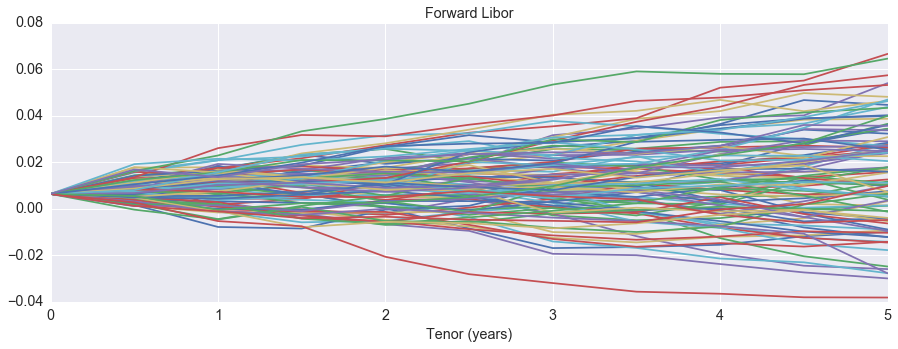

In [150]:
L_plus.iloc[:, 0:100].plot(title='Forward Libor')
_ = plt.xlabel('Tenor (years)')
_ = plt.legend('')  # remove legend

## Discount Factors

The DFs are implied from the HJM Forward Libor for each simulation via the formula:

$$
DF(0, T_{i+1}) = \prod_{i} \frac{1}{1 + \tau_i L(t; T_i, T_{i+1})} 
$$

which is equivalent to 'integrating under the curve'. This then gives 1000 simulations of the DF for each tenor. For simplicity, an expectation across all simulations is taken to get a single value for $DF(0, T_{i+1})$. This is then used to obtain the forward-starting discount factors $DF(T_i, T_{i+1})$ for the IRS in question, where:
$$
DF(T_i, T_{i+1}) = \frac{DF(0, T_{i+1})}{DF(0, T_i)}
$$

and by definition $DF(T_{i+1}, T_{i+1}) = 1.0$

| Tenor | 0.5          | 1.0        | 1.5          | 2.0        | 2.5          | 3.0        | 3.5          | 4.0        | 4.5          | 5.0        |
|:-----:|--------------|------------|--------------|------------|--------------|------------|--------------|------------|--------------|------------|
|  0.5  | DF(0.5, 0.5) | DF(0.5, 1) | DF(0.5, 1.5) | DF(0.5, 2) | DF(0.5, 2.5) | DF(0.5, 3) | DF(0.5, 3.5) | DF(0.5, 4) | DF(0.5, 4.5) | DF(0.5, 5) |
|  1.0  | -            | DF(1, 1)   | DF(1, 1.5)   | DF(1, 2)   | DF(1, 2.5)   | DF(1, 3)   | DF(1, 3.5)   | DF(1, 4)   | DF(1, 4.5)   | DF(1, 5)   |
|  1.5  | -            | -          | DF(1.5, 1.5) | DF(1.5, 2) | DF(1.5, 2.5) | DF(1.5, 3) | DF(1.5, 3.5) | DF(1.5, 4) | DF(1.5, 4.5) | DF(1.5, 5) |
|  2.0  | -            | -          | -            | DF(2, 2)   | DF(2, 2.5)   | DF(2, 3)   | DF(2, 3.5)   | DF(2, 4)   | DF(2, 4.5)   | DF(2, 5)   |
|  2.5  | -            | -          | -            | -          | DF(2.5, 2.5) | DF(2.5, 3) | DF(2.5, 3.5) | DF(2.5, 4) | DF(2.5, 4.5) | DF(2.5, 5) |
|  3.0  | -            | -          | -            | -          | -            | DF(3, 3)   | DF(3, 3.5)   | DF(3, 4)   | DF(3, 4.5)   | DF(3, 5)   |
|  3.5  | -            | -          | -            | -          | -            | -          | DF(3.5, 3.5) | DF(3.5, 4) | DF(3.5, 4.5) | DF(3.5, 5) |
|  4.0  | -            | -          | -            | -          | -            | -          | -            | DF(4, 4)   | DF(4, 4.5)   | DF(4, 5)   |
|  4.5  | -            | -          | -            | -          | -            | -          | -            | -          | DF(4.5, 4.5) | DF(4.5, 5) |
|  5.0  | -            | -          | -            | -          | -            | -          | -            | -          | -            | DF(5, 5)   |

The numerical values are shown in the table below:

In [156]:
DF2 = DF.copy()
np.fill_diagonal(DF2.values, 1)
DF2

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
Tenor,,,,,,,,,,,
0.0,1,0.995835,0.990963,0.985697,0.980105,0.974101,0.967832,0.961232,0.954239,0.946899,0.939187
0.5,0,1,0.995108,0.989819,0.984204,0.978175,0.97188,0.965253,0.958231,0.950859,0.943115
1.0,0,0,1,0.994686,0.989043,0.982984,0.976658,0.969998,0.962941,0.955534,0.947752
1.5,0,0,0,1,0.994327,0.988236,0.981876,0.975181,0.968086,0.960639,0.952816
2.0,0,0,0,0,1,0.993874,0.987478,0.980744,0.973609,0.96612,0.958252
2.5,0,0,0,0,0,1,0.993565,0.986789,0.97961,0.972075,0.964158
3.0,0,0,0,0,0,0,1,0.993181,0.985955,0.978371,0.970403
3.5,0,0,0,0,0,0,0,1,0.992725,0.985088,0.977066
4.0,0,0,0,0,0,0,0,0,1,0.992308,0.984226


## CVA

### MTM of the IRS

The mark-to-market value of the swap $V(T_i)$ i.e. the evolution of swap value over time is obtained via:

$
\begin{align} 
V(T_i=0)= \sum_{i=1}^{11} N \tau D(0, T_i)(L_i - K) \\
V(T_i=0.5)= \sum_{i=2}^{11} N \tau D(0.5, T_i)(L_i - K) \\
V(T_i=1.0)= \sum_{i=3}^{11} N \tau D(1.0, T_i)(L_i - K) \\
\vdots \space \space \vdots \space \space \vdots \\
V(T_i=5.0)= \sum_{i=11}^{11} N \tau D(5.0, T_i)(L_i - K)
\end{align}
$

where $N$ is the notional and $K$ the fixed agreed rate and $L_i = L(t; T_{i-1}, T_{i})$.

Here we assume a par swap by choosing $K = L(t; 0, 0.5) \approx 0.0063845$ to have zero initial cashflows upon entering the swap.

### Exposure

Finally, the exposure for each tenor $E_i$ is calculated from the positive part of the MTM simulations as:
$$
E_i = max(V_i, 0)
$$

The figure below shows sample simulations of the exposure profile.

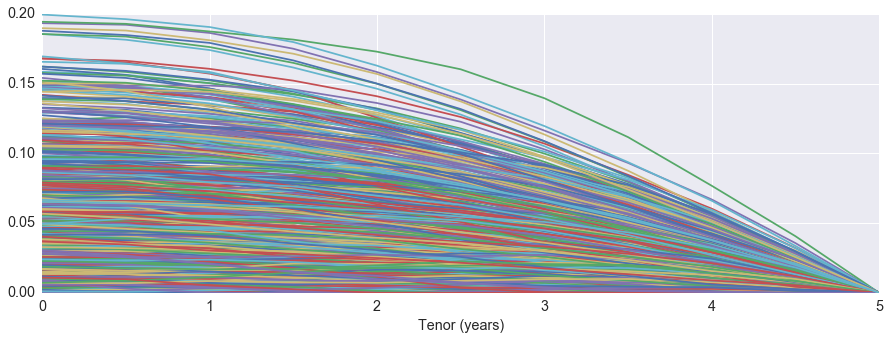

In [164]:
E_plus.loc[:, E_plus.loc[0.5] > 0].plot().plot(title='Exposure Profiles')
_ = plt.xlabel('Tenor (years)')
_ = plt.legend('')  # remove legend

### Expected Exposure

The Expected Exposure (EE) is calculated as the median of the Exposure profile. The median is here preferred over the mean as the latter can be skewed by large observations and is more sensitive to outliers. 

The figure below shows $EE_i$ as calculated from the mean and median, as well as the Potential Future Exposure (PFE) take to be the 97.5 percentile of the $E_i$ distribution. From this we see that using the median, the maximum EE and PFE are attained at the beginning of the swap in this case (equal to ~5.33% and ~14.89% of the notional respectively). Clearly the PFE is always bigger than the EE - in a way this tells us it is 97.5% probable that our exposure will not exceed ~14.89%.

In [183]:
print np.max(EE_plus_median)*100.0
print np.max(PFE_plus)*100.0

5.33087477088
14.8923704401


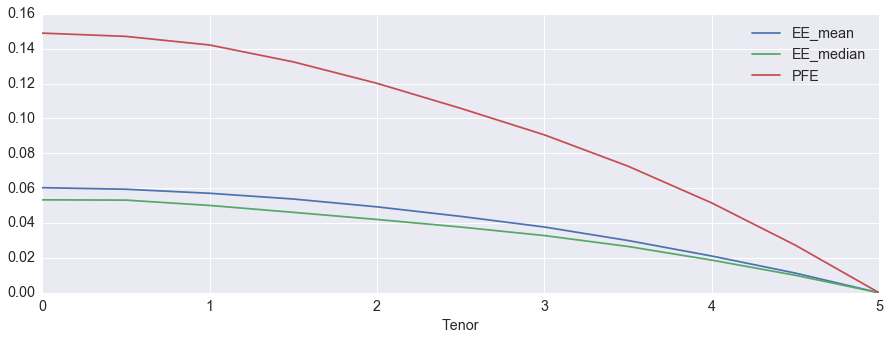

In [165]:
EE_plus_mean.plot(label="EE_mean")
EE_plus_median.plot(label="EE_median")
PFE_plus.plot(label="PFE")
plt.legend()

### CVA

Lastly, the CVA is approximated by a linear interpolation across the tenors:
$$
CVA \approx \sum_i (1-R)E(\frac{T_{i-1}-T_i}{2}) DF(\frac{T_{i-1}-T_i}{2}) PD(\frac{T_{i-1}-T_i}{2})
$$

The figure below shows each of the components in this equation

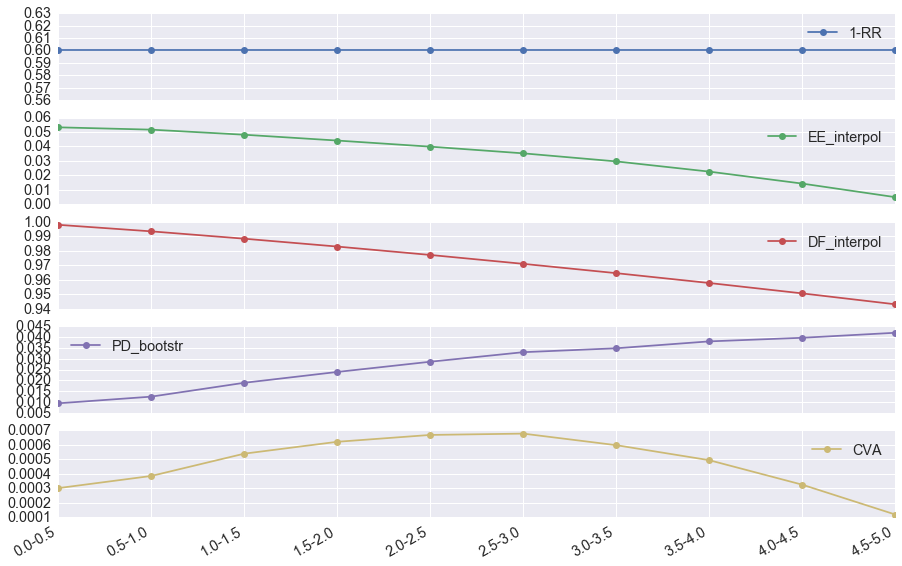

In [171]:
Loss = pd.Series(index=index_interpol, data=(1-RR))
df = pd.concat([Loss, EE_plus_median_interpol, DF_interpol, PD_interpol, CVA], axis=1,
               keys=['1-RR', 'EE_interpol', 'DF_interpol', 'PD_bootstr', 'CVA'])
_ = df.plot(subplots=True, marker='o', figsize=(15,10))
# df.plot(subplots=True, kind='bar', alpha=0.5, width=1.0)

The figure below shows the CVA for each tenor range in percentage terms over the notional value. We see a 'hump'shape telling us the maximum is found in the 2.5-3.0Y tenor period.

Based on this, the total CVA over the the lifetime of the swap amounts to ~0.473% over the notional. So for example, if the notional was \$1m, the CVA would amount to ~\$4,726

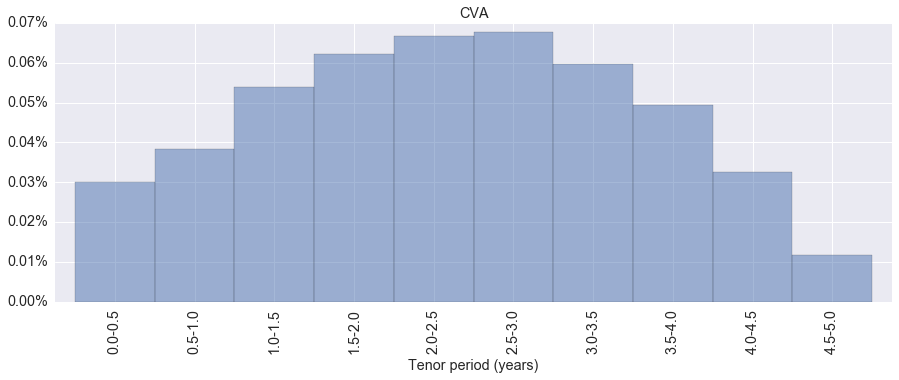

In [191]:
ax =CVA.plot.bar(width=1.0, alpha=0.5, title='CVA')
_ = plt.xlabel('Tenor period (years)')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

In [195]:
print round(CVA_total*100.0, 4)

0.4727


In [196]:
print round(CVA_total*1000000.0, 2)

4726.73
